# Requirements and imports

```
pip install requests beautifulsoup4 pandas textblob vaderSentiment transformers torch plotly WordCloud matplotlib datetime
```

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import plotly.express as px
from transformers import pipeline
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf
import numpy as np

tickers_stocks = ['AAPL', 'GOOGL', 'AMZN', 'MSFT', 'TSLA']
tickers = ['BTCUSD', 'ETHUSD']

/home/yohann/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


I have decided to work with cryptocurrencies to have continuous data for both price and news. We can do the same work with stocks but we would have to decide how to handle news coming out of market hours (which may represent a significant portion of the news).

# Data Collection

In [46]:
def scrap_google_news(ticker, nb_news):
    url = f'https://news.google.com/rss/search?q={ticker}'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'xml')
    items = soup.findAll('item')

    news = []
    for item in items[:nb_news]:
        news.append({
            'Source': "Google News",
            'Ticker': ticker,
            'Title': item.title.text,
            #'link': item.link.text,
            'Date': item.pubDate.text
        })
    data = pd.DataFrame(news)
    data['Date'] = pd.to_datetime(data['Date'], format="%a, %d %b %Y %H:%M:%S %Z")
    return data

In [50]:
def scrap_finviz_news(ticker, nb_news=5, crypto=False):
    if crypto:
        url = "https://finviz.com/crypto_charts.ashx?t={ticker}"
    else:
        url = f"https://finviz.com/quote.ashx?t={ticker}"
    headers = {'User-Agent': 'Mozilla/5.0'}  # Set User-Agent to avoid getting blocked
    response = requests.get(url, headers=headers)

    # Check if the request was successful
    if response.status_code != 200:
        print(f"Failed to retrieve data for {ticker}: {response.status_code}")
        return []

    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the news table
    news_table = soup.find(id='news-table')
    
    news_titles = []
    if news_table:
        rows = news_table.find_all('tr')
        for row in rows[:nb_news]:
            # The news title is usually in the second column
            title_column = row.find_all('td')[1] if len(row.find_all('td')) > 1 else None
            if title_column:
                title = title_column.get_text(strip=True)
                #link = title_column.find('a')['href'] if title_column.find('a') else None
                date = row.find_all('td')[0].get_text(strip=True)
                news_titles.append({'Source': "Finviz",
                                    'Ticker': ticker,
                                    'Title': title,
                                    #'link': link,
                                    'Date': date})
    data = pd.DataFrame(news_titles)
    #Change the date format to have a datetime object
    for i in range(len(data)):
        if("Today" in data.loc[i, 'Date']):
            data.loc[i, 'Date'] = data.loc[i, 'Date'].replace("Today", datetime.today().strftime('%b-%d-%y'))
        elif(data.loc[i, 'Date'][0] in '0123456789'):
            data.loc[i, 'Date'] = str(data.loc[i-1, 'Date'])[:10]+" "+data.loc[i, 'Date']
    data['Date'] = pd.to_datetime(data['Date'], format="%b-%d-%y %I:%M%p")
    return data

In [51]:
df = pd.DataFrame(columns=['Source', 'Ticker', 'Title', 'Date'])
nb_news = 50
crypto=True

for ticker in tickers:
    if(df.empty): #to avoid a warning
        df = scrap_google_news(ticker, nb_news)
        df = pd.concat([df, scrap_finviz_news(ticker, nb_news, crypto)], ignore_index=True)
    else:
        df = pd.concat([df, scrap_google_news(ticker, nb_news)], ignore_index=True)
        df = pd.concat([df, scrap_finviz_news(ticker, nb_news, crypto)], ignore_index=True)

# Sentiment analysis

TextBlob and VADER are two popular sentiment analysis tools but seem to be too general for financial news. Even BERT seems to struggle with some financial news.

In [ ]:
# Load sentiment analysis pipeline
# model from https://huggingface.co/ProsusAI/finbert/discussions/21
sentiment_analysis = pipeline("sentiment-analysis", model="ProsusAI/finbert")

# Function to get sentiment using BERT
def get_sentiment_bert(text):
    result = sentiment_analysis(text)
    return result[0]['label'], result[0]['score']

# Apply sentiment analysis
df['sentiment_label'], df['sentiment_score'] = zip(*df['Title'].apply(get_sentiment_bert))

In [54]:
df

,Source,Ticker,Title,Date,sentiment_label,sentiment_score
0,Google News,BTCUSD,Bitcoin price (BTCUSD) forecast update - 27-09...,2024-09-27 09:14:00+00:00,neutral,0.944342
1,Google News,BTCUSD,"BTC/USD: Bitcoin Hits 2-Month High of $66,000 ...",2024-09-27 07:21:36+00:00,positive,0.698428
2,Google News,BTCUSD,MicroStrategy 2X Leveraged ETF Sees Massive In...,2024-09-27 17:04:00+00:00,positive,0.690726
3,Google News,BTCUSD,FxWirePro- BTCUSD Daily Outlook - TOKENPOST,2024-09-25 21:15:00+00:00,neutral,0.883113
4,Google News,BTCUSD,BTC/USD Signal Today - 26/09: Bullish Above $6...,2024-09-26 07:30:48+00:00,neutral,0.883784
...,...,...,...,...,...,...
195,Finviz,ETHUSD,Key Indicators Challenge Fed's 'Normalization'...,2024-09-26 03:40:00,neutral,0.575999
196,Finviz,ETHUSD,"Taurus, Aktionariat partner to enable trading ...",2024-09-26 03:00:00,neutral,0.903161
197,Finviz,ETHUSD,Bitcoin ETF Demand Grows Among U.S. Investors ...,2024-09-26 02:15:00,positive,0.934928
198,Finviz,ETHUSD,NYC’s pro-crypto Mayor Eric Adams indicted on ...,2024-09-25 22:15:00,neutral,0.537830


In [56]:
# transform the sentiment_score as negative when the sentiment_label is negative
df['sentiment_score'] = df['sentiment_score'].where(df['sentiment_label'] == 'positive', -df['sentiment_score'])

In [ ]:
tickers_yf = [str(ticker[:3])+"-"+str(ticker[3:]) for ticker in tickers]    #change the ticker for cryptos to the one used by yfinance
prices = yf.download(tickers_yf, period="5d", interval='1h')['Adj Close']

hourly_returns = prices.pct_change(fill_method=None).dropna()   #calculate the hourly returns from the prices
hourly_returns.index=pd.to_datetime(hourly_returns.index.strftime('%Y-%m-%d %H'))

[*********************100%%**********************]  2 of 2 completed


In [ ]:
# Process the data to have sentiments per hour and per ticker
hourly_sentiments = pd.DataFrame(df.groupby(["Date","Ticker"])['sentiment_score'].mean())
hourly_sentiments["Ticker"] = hourly_sentiments.index.get_level_values(1)   #to have the ticker as a column
hourly_sentiments.index = hourly_sentiments.index.get_level_values(0)   #to have the date as the index
hourly_sentiments = hourly_sentiments[hourly_sentiments.index>hourly_returns.index[0]]   #remove the old news
hourly_sentiments = hourly_sentiments.reset_index().pivot(index='Date', columns='Ticker', values='sentiment_score').fillna(0)   #pivot the table to have the tickers as columns
hourly_returns.columns = hourly_sentiments.columns   #to have the same columns for the returns and the sentiments
hourly_returns.index.name = hourly_sentiments.index.name    #to have the same index name for the returns and the sentiments

```python
df.to_csv('news.csv', index=False)
hourly_returns.to_csv('hourly_returns.csv')
hourly_sentiments.to_csv('hourly_sentiments.csv')
```

```python
df = pd.read_csv('news.csv')
df['Date'] = pd.to_datetime(pd.to_datetime(df['Date'], format='ISO8601').dt.strftime('%Y-%m-%d %H'))

hourly_returns = pd.read_csv('hourly_returns.csv')
hourly_sentiments = pd.read_csv('hourly_sentiments.csv')
hourly_returns.index = pd.to_datetime(hourly_returns['Date'])
hourly_sentiments.index = pd.to_datetime(hourly_sentiments['Date'])
hourly_returns.drop(columns=['Date'], inplace=True)
hourly_sentiments.drop(columns=['Date'], inplace=True)
```

# Data Visualization

In [61]:
# Create a pie chart of sentiment_label
categories=df["Source"].unique()
figs = {categorie: px.pie(df[df['Source']==categorie], values=[1]*df[df['Source']==categorie].shape[0], names=df[df['Source']==categorie]["sentiment_label"]) for categorie in categories}

categorie_1 = categories[0]
fig = figs[categorie_1].update_traces(visible=True)
for categorie in categories:
    if categorie != categorie_1:
        fig.add_traces(figs[categorie].data)
        
fig.update_layout(
    updatemenus=[
        {
            "buttons": [
                {
                    "label": categorie,
                    "method": "update",
                    "args": [{"visible": [categorie_2 == categorie for categorie_2 in categories]}, {"title": categorie}]
                }
                for categorie in categories[::-1]
            ]
        }
    ]
)

fig.show()

In [64]:
# Create a pie chart of sentiment_label
categories=df["Source"].unique()
figs = {categorie: px.histogram(df[df['Source']==categorie], x=df[df['Source']==categorie]["sentiment_score"], nbins=20) for categorie in categories}

categorie_1 = categories[0]
fig = figs[categorie_1].update_traces(visible=True)
for categorie in categories:
    if categorie != categorie_1:
        fig.add_traces(figs[categorie].data)
        
fig.update_layout(
    updatemenus=[
        {
            "buttons": [
                {
                    "label": categorie,
                    "method": "update",
                    "args": [{"visible": [categorie_2 == categorie for categorie_2 in categories]}, {"title": categorie}]
                }
                for categorie in categories
            ]
        }
    ]
)

fig.show()

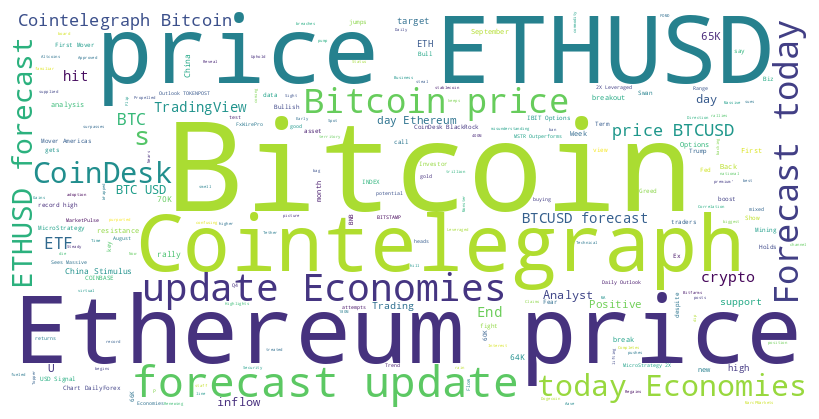

In [66]:
text = ' '.join(df['Title'].values)

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)

# Display the generated image:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [24]:
#plot the hourly returns and sentiments on the same graph
fig = px.line(hourly_returns*100, title='Hourly returns and sentiments')
fig.add_scatter(x=hourly_sentiments.index, y=hourly_sentiments['BTCUSD'], mode='lines', name='BTCUSD Sentiment')
fig.add_scatter(x=hourly_sentiments.index, y=hourly_sentiments['ETHUSD'], mode='lines', name='ETHUSD Sentiment')
fig.show()

From the chart above, no correlation is observed between the sentiment and the returns. 

In [25]:
for ticker in tickers:
    correlation = hourly_returns[ticker].corr(hourly_sentiments[ticker])
    print(f'{ticker}: {correlation:.2f}')

BTCUSD: 0.08
ETHUSD: 0.04


This confirms the absence of correlation between the sentiment and the returns. 

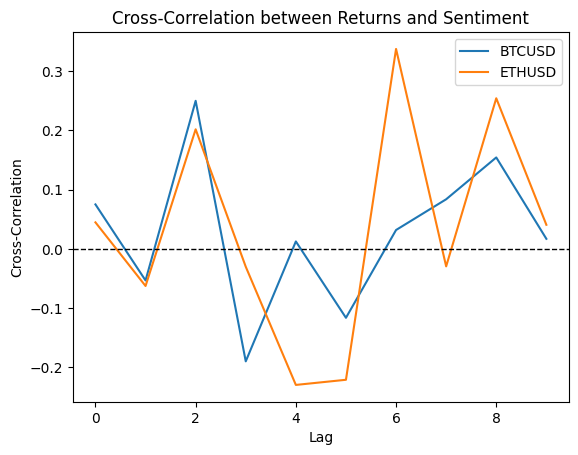

In [36]:
from statsmodels.tsa.stattools import ccf

data = hourly_returns.join(hourly_sentiments, how='inner', lsuffix="_return", rsuffix="_sentiment")

for ticker in tickers:
    #inner join the two dataframes
    cross_correlation = ccf(data[ticker+"_return"], data[ticker+"_sentiment"], nlags=10)
    plt.plot(cross_correlation, label=ticker)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.legend()
plt.title('Cross-Correlation between Returns and Sentiment')
plt.show()

Even with lags, the correlation is not significant. This means that the sentiment of the news is not a good predictor of the returns, even in the case where the market would react with a delay to the news.

In [27]:
from statsmodels.tsa.stattools import coint

for ticker in tickers:
    result = coint(data[ticker+"_return"], data[ticker+"_sentiment"])
    print(f'{ticker}: score={result[0]:.2f}, p-value={result[1]:.2f}') 

BTCUSD: score=-7.20, p-value=0.00
ETHUSD: score=-6.41, p-value=0.00


From the cointegration test, the return and sentiment time series seem to be cointegrated for both cryptocurrencies. This is surprising as the returns and sentiment are not correlated and should be confirmed by further analysis.

I am strongly limited by the quantity of data I can handle. To deal with this, I have focused my analysis on a couple of hours. As we have seen, it seems that no clear relationship between financial news and crypto returns can be observed in this short time frame. However, market sentiments may have a long-term relationship with returns. It would be interesting to a daily or weekly window with a longer history to assess a potential relationship.

# Improvements


Use more data to to analyze a longer period of time and potnetially observing a long-term relationship between returns and sentiment. It might also be interesting to test with different cryptocurrencies or stocks.

Use tweepy to get the tweets and the sentiment analysis. See the following model in case of using tweets: StephanAkkerman/FinTwitBERT

```python
import tweepy
import pandas as pd

# Authenticate to Twitter
auth = tweepy.OAuth1UserHandler(consumer_key, consumer_secret, access_token, access_token_secret)
api = tweepy.API(auth)

def fetch_tweets(stock_ticker, count=100):
    query = f"${stock_ticker} OR {stock_ticker}"  # Use $ for stock symbols
    tweets = api.search(q=query, count=count, lang='en', tweet_mode='extended')
    
    data = []
    for tweet in tweets:
        data.append({
            'text': tweet.full_text,
            'created_at': tweet.created_at,
            'user': tweet.user.screen_name,
            'sentiment': None  # Placeholder for sentiment later
        })
    
    return pd.DataFrame(data)
```

sentiment analysis with nltk: https://medium.com/@deepml1818/financial-sentiment-analysis-and-stock-information-retrieval-with-python-a1d6e821deb6

ML on sentiment analysis (with data): https://www.kaggle.com/code/chibss/financial-sentiment-analysis/notebook

terminal open-source: https://github.com/OpenBB-finance/OpenBB

example of sentiment analysis: https://github.com/SaloniJhalani/Stock-Market-Live-Sentiment/blob/main/update_sentiment_page.py

